# 첫 번째 신경망 훈련하기: 기초적인 분류 문제


이 튜토리얼에서는 운동화나 셔츠 같은 옷 이미지를 분류하는 신경망 모델을 훈련합니다. 상세 내용을 모두 이해하지 못해도 괜찮습니다.
여기서는 완전한 텐서플로(TensorFlow) 프로그램을 빠르게 살펴 보겠습니다. 자세한 내용은 앞으로 배우면서 더 설명합니다.

여기에서는 텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 tf.keras를 사용합니다.

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0


패션 MNIST 데이터셋 임포트하기
10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

Fashion MNIST sprite
그림 1. 패션-MNIST 샘플 (Zalando, MIT License).

<img src = "https://tensorflow.org/images/fashion-mnist-sprite.png">
 
패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 MNIST 데이터셋을 대신해서 자주 사용됩니다. MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있습니다. 여기서 사용하려는 옷 이미지와 동일한 포맷입니다.

패션 MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제이고 다양한 예제를 만들기 위해 선택했습니다. 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다.

네트워크를 훈련하는데 60,000개의 이미지를 사용합니다. 그다음 네트워크가 얼마나 정확하게 이미지를 분류하는지 10,000개의 이미지로 평가하겠습니다. 패션 MNIST 데이터셋은 텐서플로에서 바로 임포트하여 적재할 수 있습니다:

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:

train_images와 train_labels 배열은 모델 학습에 사용되는 훈련 세트입니다.
test_images와 test_labels 배열은 모델 테스트에 사용되는 테스트 세트입니다.
이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이입니다. 레이블(label)은 0에서 9까지의 정수 배열입니다. 
이 값은 이미지에 있는 옷의 클래스(class)를 나타냅니다:

|레이블|클래스|
|---|:---|
|0|T-shirt/top
|1|Trouser    
|2|Pullover   
|3|Dress      
|4|Coat       
|5|Sandal     
|6|Shirt      
|7|Sneaker    
|8|Bag        
|9|Ankle boot 

각 이미지는 하나의 레이블에 매핑되어 있습니다. 데이터셋에 클래스 이름이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 
별도의 변수를 만들어 저장합니다:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다:

In [6]:
train_images.shape

(60000, 28, 28)

비슷하게 훈련 세트에는 60,000개의 레이블이 있습니다

In [7]:
len(train_labels)

60000

각 레이블은 0과 9사이의 정수입니다:

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있습니다. 이 이미지도 28x28 픽셀로 표현됩니다:

In [9]:
test_images.shape

(10000, 28, 28)

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있습니다:

In [11]:
len(test_labels)

10000

# 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수
있습니다:

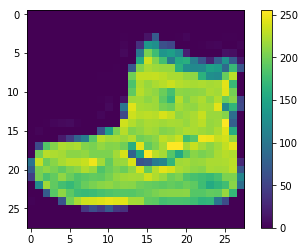

In [12]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. 훈련 세트와 테스트 세트를 동일한 방식으로 전처리하는 것이 중요합니다:

In [13]:
train_images = train_images / 255.0

test_images = test_images / 255.0

훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

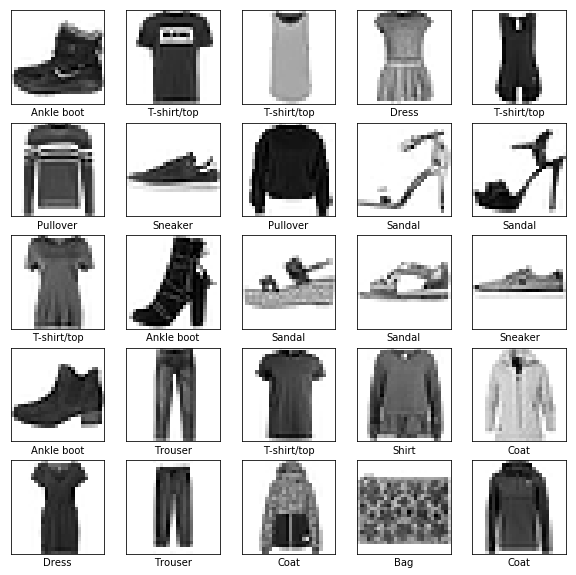

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 모델 구성

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일합니다.

### 층 설정
신경망의 기본 구성 요소는 층(layer)입니다. 층은 주입된 데이터에서 표현을 추출합니다. 아마도 문제를 해결하는데 더 의미있는 표현이 추출될 것입니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

이 네트워크의 첫 번째 층인 tf.keras.layers.Flatten은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 합니다.

픽셀을 펼친 후에는 두 개의 tf.keras.layers.Dense 층이 연속되어 연결됩니다. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력합니다.

### 모델 컴파일

모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

**손실 함수(Loss function)** 훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다.

**옵티마이저(Optimizer)** 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.

**지표(Metrics)** 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 모델 훈련

신경망 모델을 훈련하는 단계는 다음과 같습니다:

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 train_images와 train_labels 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 test_images 배열입니다. 이 예측이 test_labels 배열의 레이블과 맞는지 확인합니다.

훈련을 시작하기 위해 model.fit 메서드를 호출하면 모델이 훈련 데이터를 학습합니다:

In [17]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 3s 56us/step - loss: 0.4946 - acc: 0.8245
Epoch 2/5
60000/60000 [==============================] - 2s 38us/step - loss: 0.3749 - acc: 0.8648
Epoch 3/5
60000/60000 [==============================] - 2s 38us/step - loss: 0.3369 - acc: 0.8785
Epoch 4/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.3126 - acc: 0.8858
Epoch 5/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.2939 - acc: 0.8927


모델이 훈련되면서 손실과 정확도 지표가 출력됩니다. 이 모델은 훈련 세트에서 약 0.88(88%) 정도의 정확도를 달성합니다.

### 정확도 평가

그다음 테스트 세트에서 모델의 성능을 비교합니다:


In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)


테스트 정확도: 0.8796


테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮습니다. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문입니다. 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말합니다.

### 예측 만들기

훈련된 모델을 사용하여 이미지에 대한 예측을 만들 수 있습니다.

In [19]:
predictions = model.predict(test_images)

여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측했습니다. 첫 번째 예측을 확인해 보죠:

In [20]:
predictions[0]

array([1.7251662e-06, 4.0708781e-07, 5.0870277e-08, 2.0766951e-08,
       2.1845769e-07, 7.9705985e-03, 3.6143349e-05, 3.3929519e-02,
       1.0139897e-05, 9.5805120e-01], dtype=float32)

이 예측은 10개의 숫자 배열로 나타납니다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 찾아보죠:

In [21]:
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클 부츠(class_name[9])라고 가장 확신하고 있습니다. 이 값이 맞는지 테스트 레이블을 확인해 보죠:

In [23]:
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현해 보겠습니다:

In [25]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해 보겠습니다.

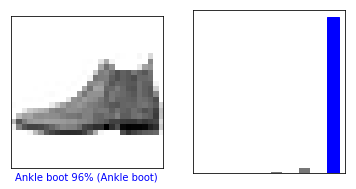

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

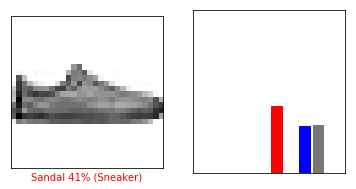

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

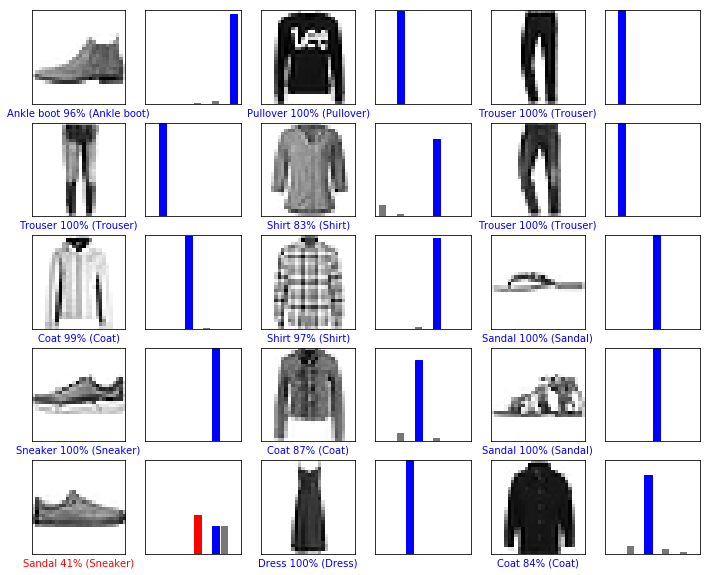

In [28]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

마지막으로 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듭니다.

In [30]:
# 테스트 세트에서 이미지 하나를 선택합니다
img = test_images[0]

print(img.shape)

(28, 28)


tf.keras 모델은 한 번에 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화되어 있습니다. 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 합니다:

In [31]:
# 이미지 하나만 사용할 때도 배치에 추가합니다
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


이제 이 이미지의 예측을 만듭니다:

In [39]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.7251647e-06 4.0708738e-07 5.0870277e-08 2.0766951e-08 2.1845769e-07
  7.9705939e-03 3.6143312e-05 3.3929486e-02 1.0139877e-05 9.5805120e-01]]


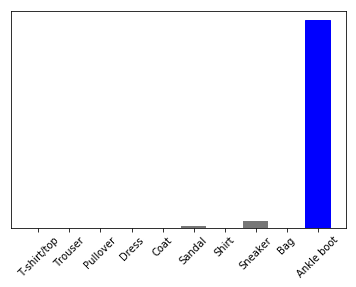

In [40]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

model.predict는 2차원 넘파이 배열을 반환하므로 첫 번째 이미지의 예측을 선택합니다:

In [41]:
np.argmax(predictions_single[0])

9

이전과 마찬가지로 모델의 예측은 레이블 9입니다.